## Charge needed libraries

In [9]:
library(tidyverse)
library(magrittr)
library(janitor)
library(patchwork)
library(FAVA)
library(dplyr)
library(ggplot2)

## Load sylph taxonomy data

In [14]:
sylph <- read_csv("../data/sylph.csv", show_col_types = FALSE)

## Load meteor taxonomy data and transform it into a sylph-like dataframe

In [15]:
# ---- 1) Read METEOR table ----
meteor_raw <- read_csv("../data/meteor.csv", show_col_types = FALSE)
meta_cols <- c("clade_name","gtdb_r214_classification",
               "superkingdom","phylum","class","order","family","genus","species")
sample_cols <- setdiff(names(meteor_raw), meta_cols)

# ---- 2) Convert coverages to per-sample frequencies ----
meteor_freq <- meteor_raw %>%
  mutate(across(all_of(sample_cols), ~ .x / sum(.x, na.rm = TRUE)))

# ---- 3) Build prefixed GTDB-style taxonomy columns ----
rank_cols <- c("superkingdom","phylum","class","order","family","genus","species")
pref_cols <- c("d","p","c","o","f","g","s")

meteor_pref <- meteor_freq %>%
  mutate(across(all_of(rank_cols), ~ na_if(.x, ""))) %>%
  mutate(
    d = if_else(is.na(superkingdom), NA_character_, paste0("d__", superkingdom)),
    p = if_else(is.na(phylum),       NA_character_, paste0("p__", phylum)),
    c = if_else(is.na(class),        NA_character_, paste0("c__", class)),
    o = if_else(is.na(order),        NA_character_, paste0("o__", order)),
    f = if_else(is.na(family),       NA_character_, paste0("f__", family)),
    g = if_else(is.na(genus),        NA_character_, paste0("g__", genus)),
    s = if_else(is.na(species),      NA_character_, paste0("s__", species))
  )

# Helper to aggregate frequencies at a given rank depth (1=domain|phylum ... 6=...|species)
agg_level <- function(df_pref, depth, sample_cols) {
  stopifnot(depth >= 1, depth <= length(pref_cols))
  clade_df <- df_pref %>%
    select(all_of(pref_cols[1:depth])) %>%
    tidyr::unite("clade_name", everything(), sep = "|", na.rm = TRUE)
  bind_cols(clade_df, df_pref[sample_cols]) %>%
    dplyr::filter(clade_name != "") %>%
    group_by(clade_name) %>%
    summarise(across(all_of(sample_cols), ~ sum(.x, na.rm = TRUE)), .groups = "drop")
}

# ---- 4) Build a single “sylph-like” table with all ranks stacked ----
levels_list <- lapply(1:length(pref_cols), function(d) agg_level(meteor_pref, d, sample_cols))
meteor <- bind_rows(levels_list)
                      
# ---- 5) Clean workspace ----

 rm(list=ls()[!ls() %in% c("sylph","meteor")])

## Calculate FAVA for both dfs

In [ ]:
f_s <- run_fava_minimal(
  df = sylph,
  levels = 1:7,
  subsets = c("rarefied", "unrarefied"),
  bootstrap_reps = 500,
  seed = 123
)

In [ ]:
f_m <- run_fava_minimal(
  df = meteor,
  levels = 1:7,
  subsets = c("rarefied", "unrarefied"),
  bootstrap_reps = 500,
  seed = 123
)

In [31]:
f_m %>% mutate(method = "meteor") %>% rbind((f_s %>%  mutate(method = "sylph"))) -> f ; rm(f_s, f_m)

## Plot FAVA results

In [17]:
tax_labels <- c(
               `1` = "Phylum",
               `2` = "Class",
               `3` = "Order",
               `4` = "Family",
               `5` = "Genus",
               `6` = "Species",
               `7` = "Strain"
             )

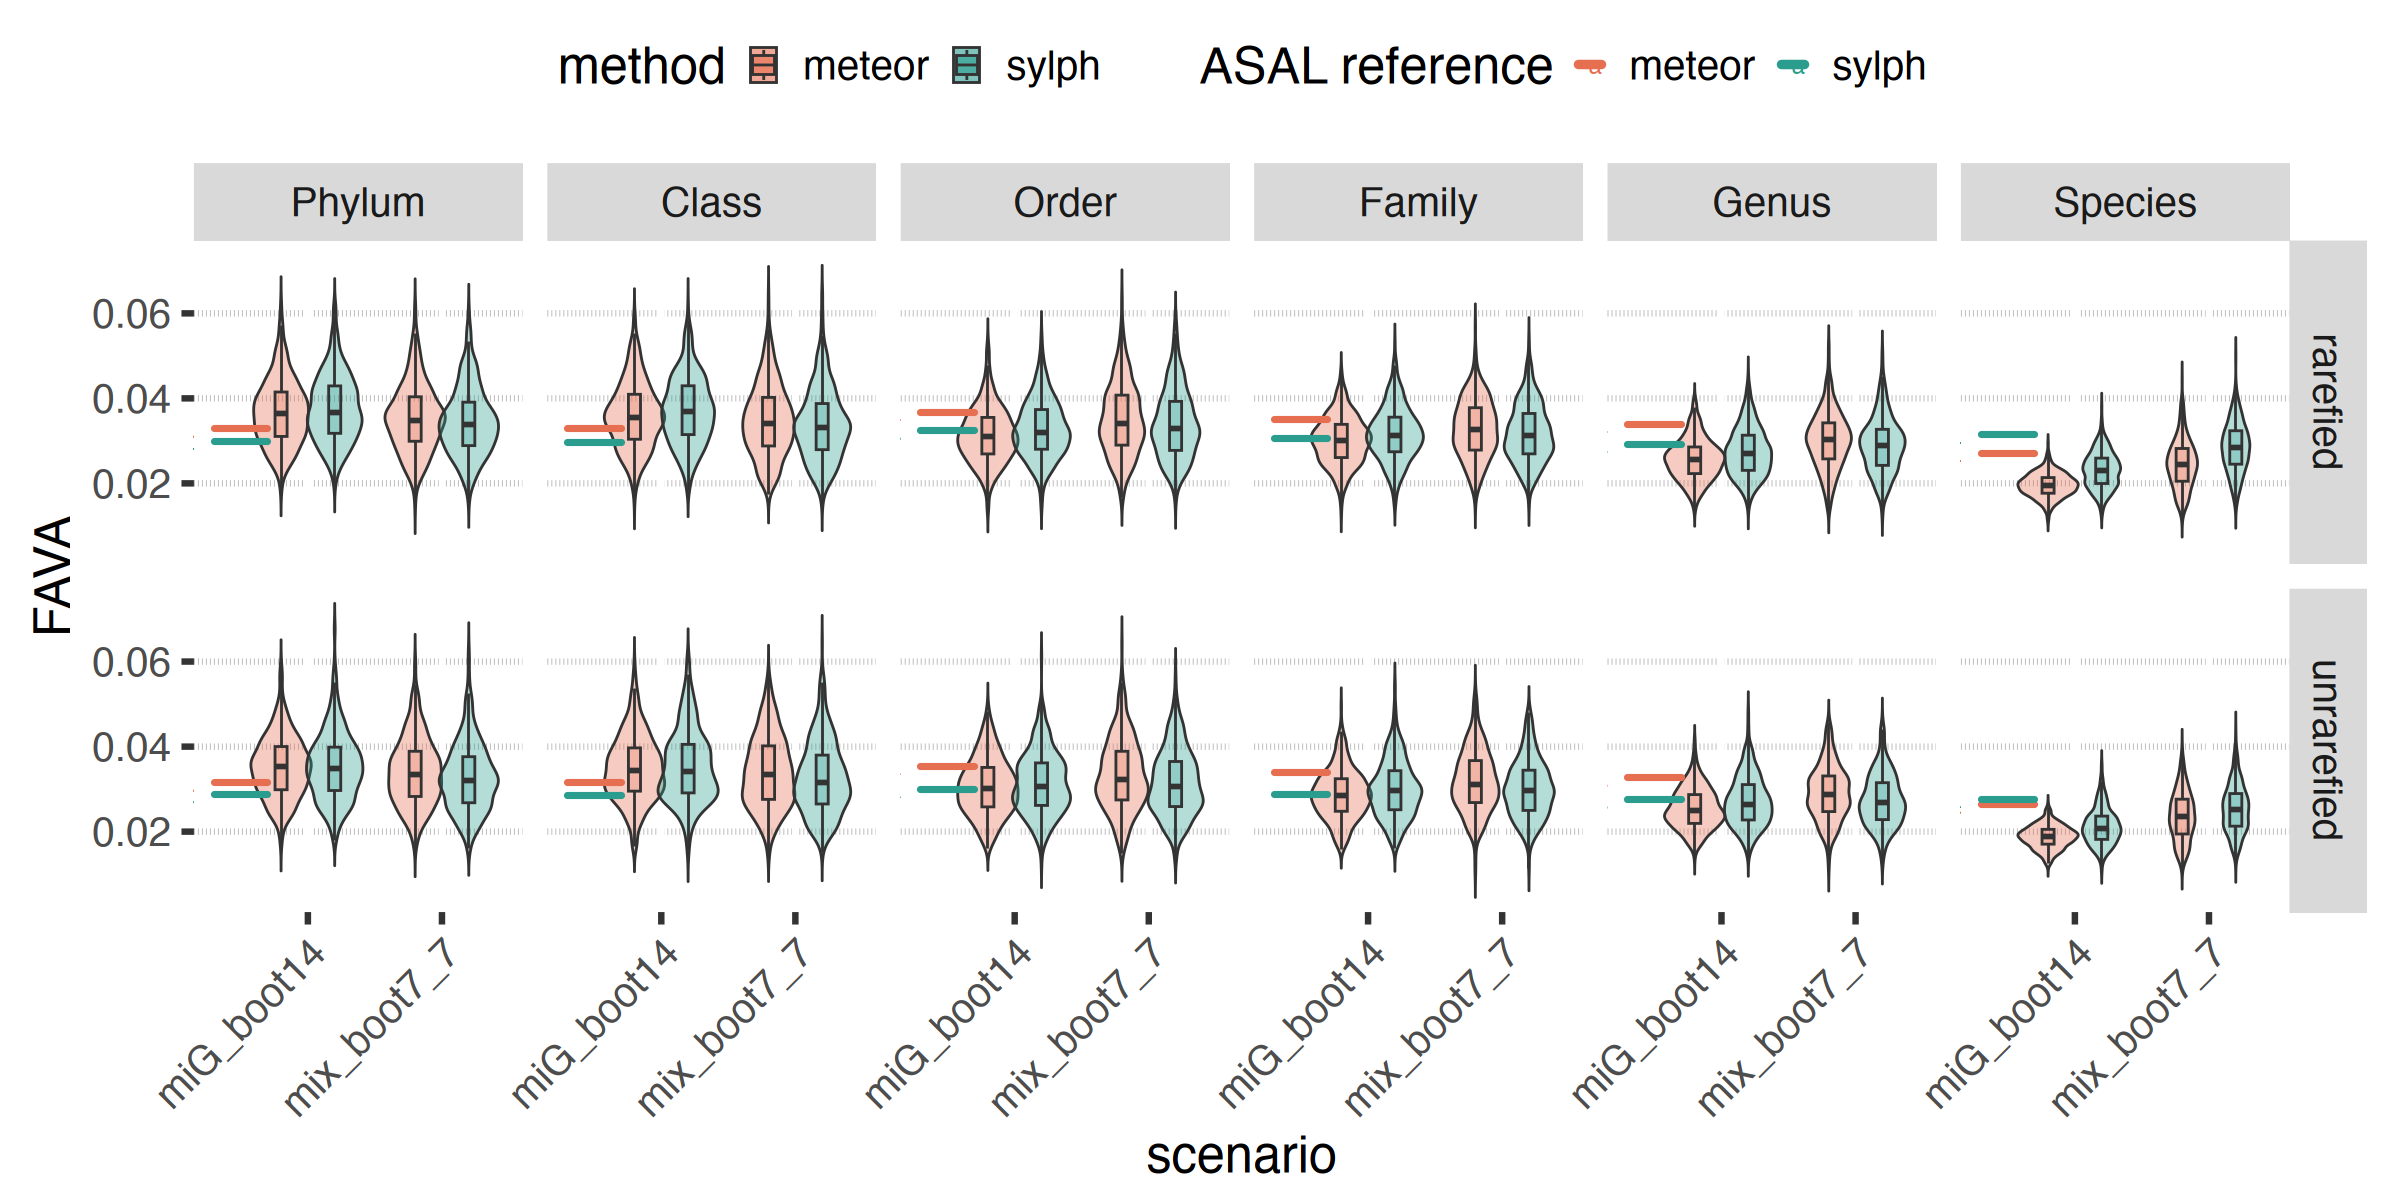

In [45]:
# --- ASAL reference lines per method × level × subset ---
asal_fava_lines <- f %>%
  filter(scenario == "ASAL_all14", is.na(bootstrap), level != 7) %>%
  select(method, level, subset, FAVA) %>%
  distinct()

# --- Plot: combine methods, facet by rarefied/unrarefied ---
p <- f %>%
  filter(!is.na(bootstrap), level != 7) %>%
  ggplot(aes(x = scenario, y = FAVA, fill = method)) +

  # violins + boxes (dodged by method)
  geom_violin(
    aes(group = interaction(scenario, method)),
    position = position_dodge(width = 0.8),
    alpha = 0.35,
    linewidth = 0.6,
    trim = FALSE
  ) +
  geom_boxplot(
    aes(group = interaction(scenario, method)),
    width = 0.18,
    position = position_dodge(width = 0.8),
    outlier.shape = NA,
    alpha = 0.25,
    linewidth = 0.6
  ) +

  # --- Add short ASAL bars at the left margin ---
  geom_segment(
    data = asal_fava_lines,
    aes(
      x = 0.3, xend = 0.7,   # short bar before violins
      y = FAVA, yend = FAVA,
      color = method
    ),
    inherit.aes = FALSE,
    linewidth = 1.5,
    lineend = "round"
  ) +
  geom_text(
    data = asal_fava_lines,
    aes(x = 0.15, y = FAVA, label = "ASAL", color = method),
    inherit.aes = FALSE,
    size = 5,
    fontface = "bold",
    hjust = 1
  ) +

  facet_grid(
    subset ~ level,
    labeller = labeller(level = as_labeller(tax_labels)),
    scales = "free_x"
  ) +

  # unified palette for methods
  scale_fill_manual(
    name = "method",
    values = c(meteor = "#E76F51", sylph = "#2A9D8F")
  ) +
  scale_color_manual(
    name = "ASAL reference",
    values = c(meteor = "#E76F51", sylph = "#2A9D8F")
  ) +

  ggpubr::theme_pubclean(base_size = 30) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "top",
    panel.grid.minor.y = element_blank(),
    plot.margin = margin(l = 20, r = 20, t = 10, b = 10)
  ) +
  guides(
    fill = guide_legend(order = 1, override.aes = list(alpha = 0.6)),
    color = guide_legend(order = 2, override.aes = list(linewidth = 2))
  )

p
